In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
# Option1: Use IBM Quantum backend.
# Set up the Qiskit Runtime service (this is a one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['x', 'id', 'measure', 'reset', 'sx', 'cz']>)


In [5]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [ ]:
# Load parameters
# CURRENT_TIME can be found in data_generate.ipynb
CURRENT_TIME = "2024-12-02T09:24Z"
path = f"./data/{CURRENT_TIME}"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

for key, value in params.items():
    print(f"{key}: {value}")

# Create Fourier feature

## Trotter simulation (QPU)

In [7]:
initial_layout = get_initial_layout(n_qubits, graph_type, backend_qpu.name)

In [8]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}
lambda_refs = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    lambda_refs[f"sample{i}"] = np.sum(Js)  # Reference eigenvalue.
    heisenberg_qpu = HeisenbergModel(n_qubits, graphs[i], backend=backend_qpu)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0, initial_layout=initial_layout
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1, initial_layout=initial_layout
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2, initial_layout=initial_layout
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3, initial_layout=initial_layout
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/108
Creating circuits for sample 1/108
Creating circuits for sample 2/108
Creating circuits for sample 3/108
Creating circuits for sample 4/108
Creating circuits for sample 5/108
Creating circuits for sample 6/108
Creating circuits for sample 7/108
Creating circuits for sample 8/108
Creating circuits for sample 9/108
Creating circuits for sample 10/108
Creating circuits for sample 11/108
Creating circuits for sample 12/108
Creating circuits for sample 13/108
Creating circuits for sample 14/108
Creating circuits for sample 15/108
Creating circuits for sample 16/108
Creating circuits for sample 17/108
Creating circuits for sample 18/108
Creating circuits for sample 19/108
Creating circuits for sample 20/108
Creating circuits for sample 21/108
Creating circuits for sample 22/108
Creating circuits for sample 23/108
Creating circuits for sample 24/108
Creating circuits for sample 25/108
Creating circuits for sample 26/108
Creating circuits for sample 27/108
Cr

before transpile
circuit depth: 19
count_ops: OrderedDict([('cx', 26), ('rx', 10), ('rz', 10), ('rzx', 10), ('measure', 8), ('h', 2), ('barrier', 1)])


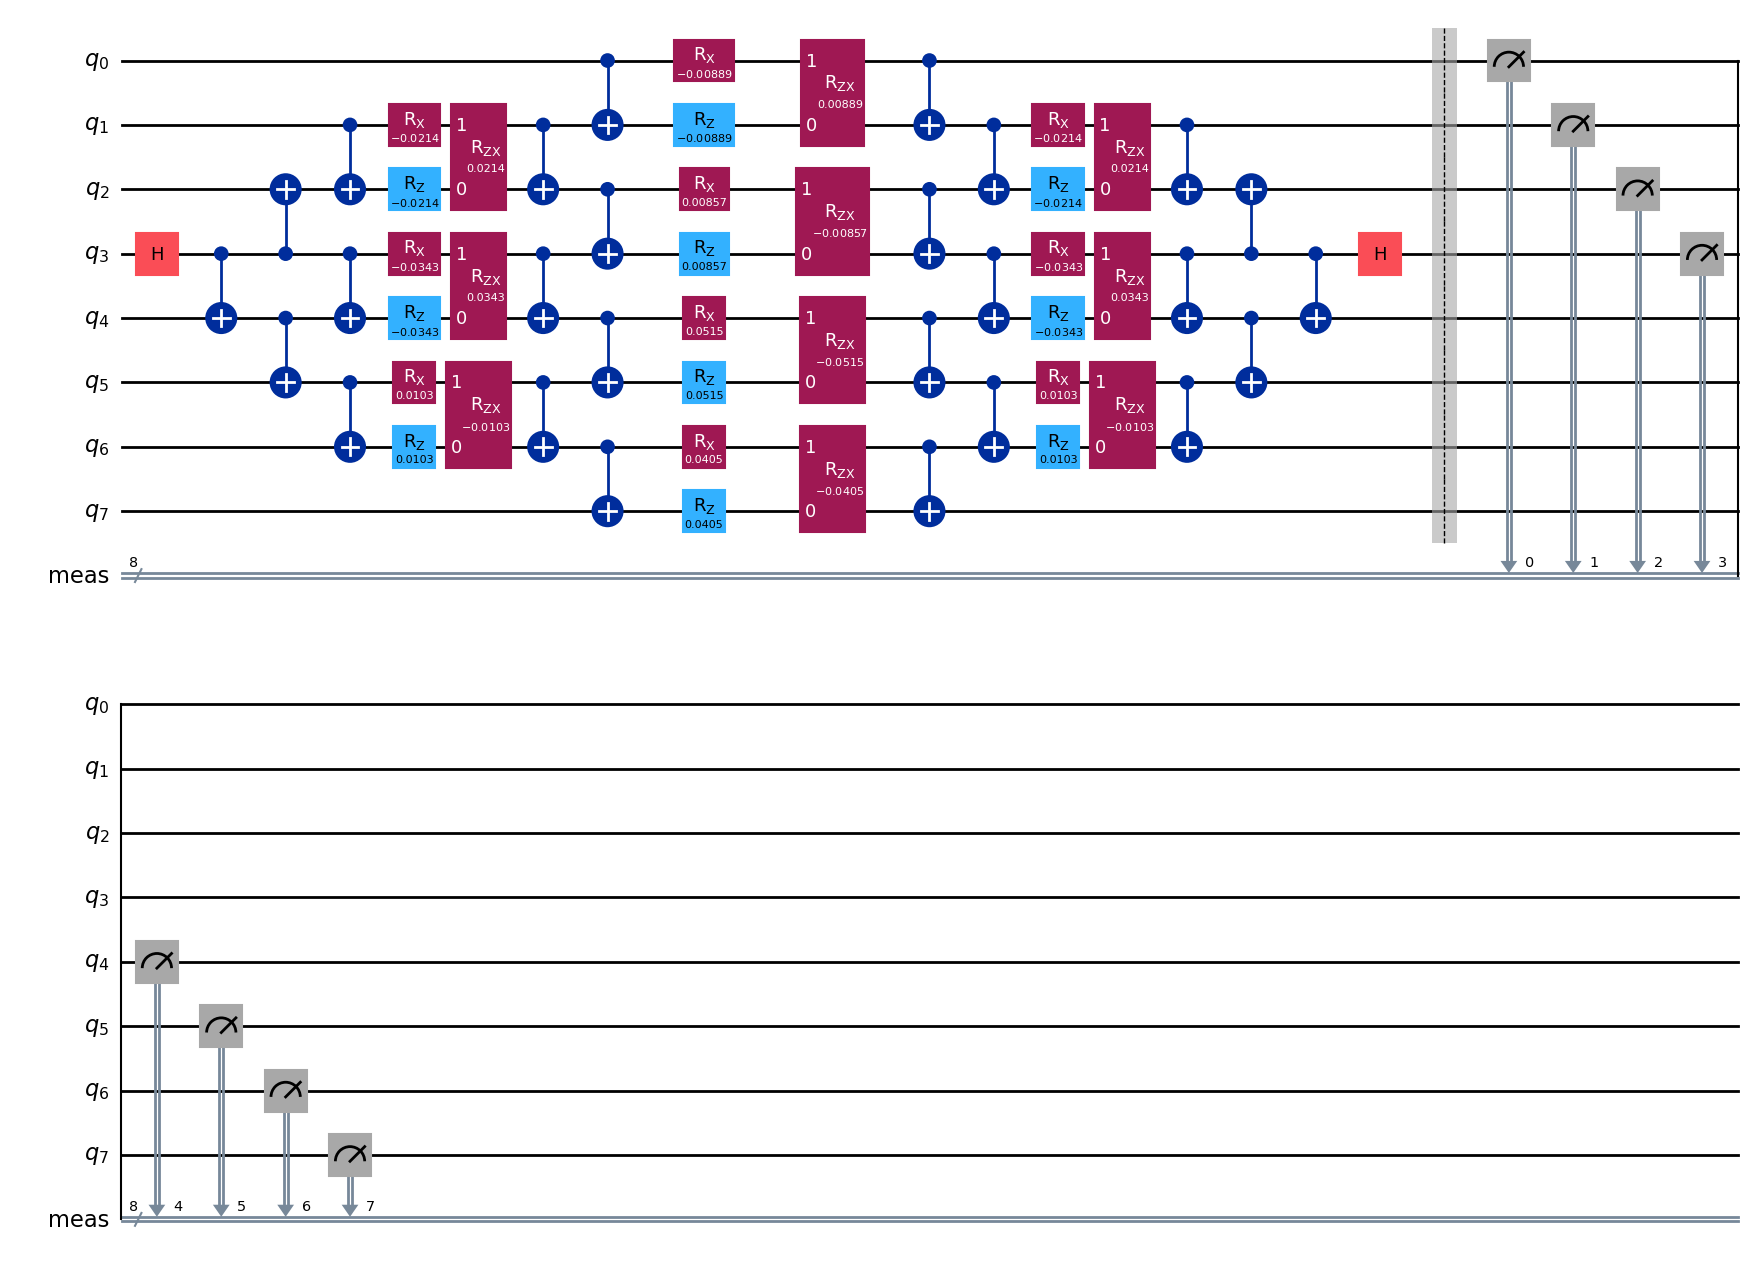

In [9]:
# Check a partial circuit
sample_id = 2
feature_id = 1

print("before transpile")
print(
    f"circuit depth: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

after transpile
circuit depth: 53
count_ops: OrderedDict([('sx', 89), ('rz', 74), ('cz', 36), ('measure', 8), ('x', 1), ('barrier', 1)])


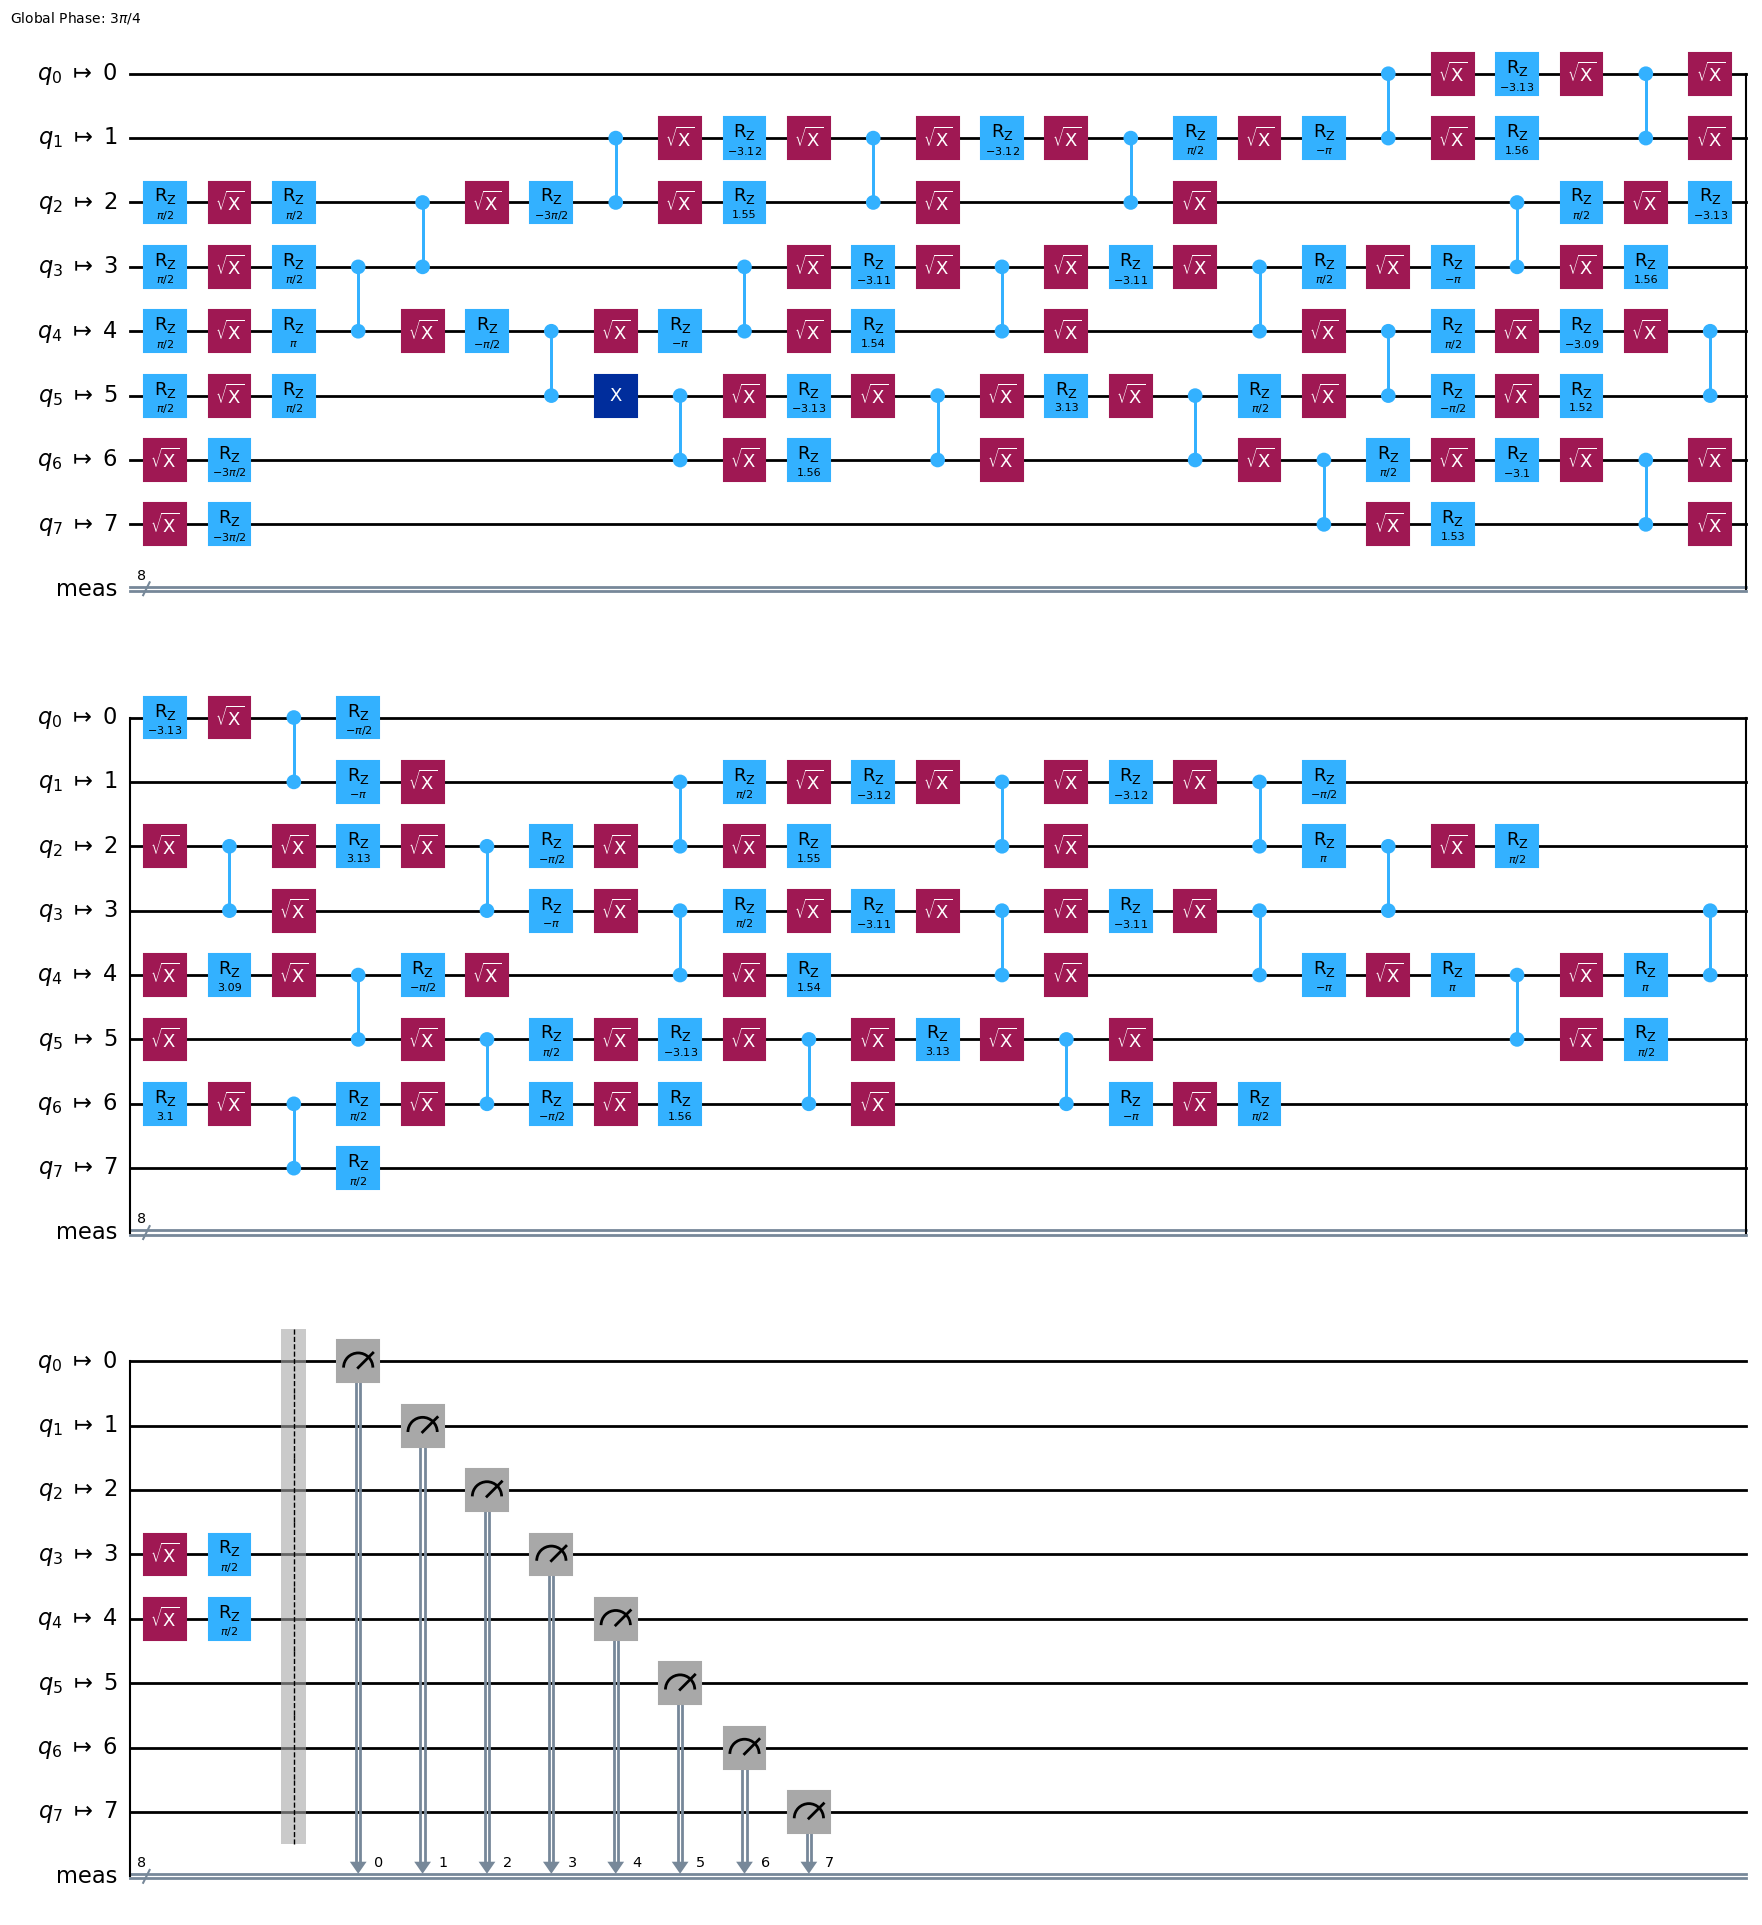

In [10]:
print("after transpile")
print(
    f"circuit depth: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
exec_circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

In [11]:
# Run jobs in batch
job_ids = []
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    for i in range(n_samples):
        print(f"Submitting circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        job_ids.append(job.job_id())

Submitting circuits for sample 0/108
Submitting circuits for sample 1/108
Submitting circuits for sample 2/108
Submitting circuits for sample 3/108
Submitting circuits for sample 4/108
Submitting circuits for sample 5/108
Submitting circuits for sample 6/108
Submitting circuits for sample 7/108
Submitting circuits for sample 8/108
Submitting circuits for sample 9/108
Submitting circuits for sample 10/108
Submitting circuits for sample 11/108
Submitting circuits for sample 12/108
Submitting circuits for sample 13/108
Submitting circuits for sample 14/108
Submitting circuits for sample 15/108
Submitting circuits for sample 16/108
Submitting circuits for sample 17/108
Submitting circuits for sample 18/108
Submitting circuits for sample 19/108
Submitting circuits for sample 20/108
Submitting circuits for sample 21/108
Submitting circuits for sample 22/108
Submitting circuits for sample 23/108
Submitting circuits for sample 24/108
Submitting circuits for sample 25/108
Submitting circuits fo

In [18]:
batch.status()

'Closed'

In [16]:
with open(f"{path}/first_try_job_ids.txt", "w") as f:
    for job_id in job_ids:
        f.write(f"{job_id}\n")

In [17]:
# Note: This line can be finished only after the calibration job (tagged with "M3 calibration") is finished.
mit.cals_to_file(f"{path}/calibrations.json")

## Post process (QPU)

In [19]:
with open(f"{path}/first_try_job_ids.txt", "r") as f:
    first_try_job_ids = [job_id.strip() for job_id in f.readlines()]

# Load calibration data
cals_file = f"{path}/calibrations.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

In [20]:
# Scan the status of the jobs
successful_job_ids_and_samples = {}
failed_job_ids_ids_and_samples = {}
successful_results = {}

for i in range(n_samples):
    print(f"Checking job {i}/{n_samples}")
    job_id = first_try_job_ids[i]
    job = service.job(job_id)

    if job.status() == "DONE":
        successful_job_ids_and_samples[f"sample{i}"] = job_id
        successful_results[f"sample{i}"] = job.result()
    elif job.status() == "ERROR":
        failed_job_ids_ids_and_samples[f"sample{i}"] = job_id

print()
print("successful samples and job ids")
for sample_id, job_id in successful_job_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print("failed samples and job ids")
for sample_id, job_id in failed_job_ids_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print(f"Success rate: { len(successful_job_ids_and_samples) / n_samples }")

with open(f"{path}/successful_job_ids_and_samples.json", "w") as f:
    json.dump(successful_job_ids_and_samples, f)
with open(f"{path}/failed_job_ids_ids_and_samples.json", "w") as f:
    json.dump(failed_job_ids_ids_and_samples, f)

Checking job 0/108
Checking job 1/108
Checking job 2/108
Checking job 3/108
Checking job 4/108
Checking job 5/108
Checking job 6/108
Checking job 7/108
Checking job 8/108
Checking job 9/108
Checking job 10/108
Checking job 11/108
Checking job 12/108
Checking job 13/108
Checking job 14/108
Checking job 15/108
Checking job 16/108
Checking job 17/108
Checking job 18/108
Checking job 19/108
Checking job 20/108
Checking job 21/108
Checking job 22/108
Checking job 23/108
Checking job 24/108
Checking job 25/108
Checking job 26/108
Checking job 27/108
Checking job 28/108
Checking job 29/108
Checking job 30/108
Checking job 31/108
Checking job 32/108
Checking job 33/108
Checking job 34/108
Checking job 35/108
Checking job 36/108
Checking job 37/108
Checking job 38/108
Checking job 39/108
Checking job 40/108
Checking job 41/108
Checking job 42/108
Checking job 43/108
Checking job 44/108
Checking job 45/108
Checking job 46/108
Checking job 47/108
Checking job 48/108
Checking job 49/108
Checking j

In [21]:
# Note: this is only for the successful jobs

data_qpu_nmit = []
data_qpu_mit = []
probs_phase0_nmit = {}
probs_phase1_nmit = {}
probs_phase2_nmit = {}
probs_phase3_nmit = {}
probs_phase0_mit = {}
probs_phase1_mit = {}
probs_phase2_mit = {}
probs_phase3_mit = {}

# Note: sample_id is string, not integer
for sample_id, result in successful_results.items():
    print(f"Processing job {sample_id}")
    features_nmit = []
    features_mit = []
    probs_phase0_nmit[sample_id] = {}
    probs_phase1_nmit[sample_id] = {}
    probs_phase2_nmit[sample_id] = {}
    probs_phase3_nmit[sample_id] = {}
    probs_phase0_mit[sample_id] = {}
    probs_phase1_mit[sample_id] = {}
    probs_phase2_mit[sample_id] = {}
    probs_phase3_mit[sample_id] = {}

    for k in range(n_features):
        # Get results of each phase in a batch
        # phase_results = result[4 * k : 4 * k + 4]
        # probs = [
        #     get_prob0(phase_result, n_qubits, mit) for phase_result in phase_results
        # ]

        # Get results of each phase in a batch
        results_phase0 = result[:n_features]
        results_phase1 = result[n_features : 2 * n_features]
        results_phase2 = result[2 * n_features : 3 * n_features]
        results_phase3 = result[3 * n_features :]

        prob_phase0_nmit, prob_phase0_mit = get_prob0(results_phase0[k], n_qubits, mit)
        prob_phase1_nmit, prob_phase1_mit = get_prob0(results_phase1[k], n_qubits, mit)
        prob_phase2_nmit, prob_phase2_mit = get_prob0(results_phase2[k], n_qubits, mit)
        prob_phase3_nmit, prob_phase3_mit = get_prob0(results_phase3[k], n_qubits, mit)

        if prob_phase0_mit > 1:
            prob_phase0_mit = 1
        elif prob_phase0_mit < 0:
            prob_phase0_mit = 0
        if prob_phase1_mit > 1:
            prob_phase1_mit = 1
        elif prob_phase1_mit < 0:
            prob_phase1_mit = 0
        if prob_phase2_mit > 1:
            prob_phase2_mit = 1
        elif prob_phase2_mit < 0:
            prob_phase2_mit = 0
        if prob_phase3_mit > 1:
            prob_phase3_mit = 1
        elif prob_phase3_mit < 0:
            prob_phase3_mit = 0

        probs_phase0_nmit[sample_id][f"f_{k}"] = prob_phase0_nmit
        probs_phase1_nmit[sample_id][f"f_{k}"] = prob_phase1_nmit
        probs_phase2_nmit[sample_id][f"f_{k}"] = prob_phase2_nmit
        probs_phase3_nmit[sample_id][f"f_{k}"] = prob_phase3_nmit
        probs_phase0_mit[sample_id][f"f_{k}"] = prob_phase0_mit
        probs_phase1_mit[sample_id][f"f_{k}"] = prob_phase1_mit
        probs_phase2_mit[sample_id][f"f_{k}"] = prob_phase2_mit
        probs_phase3_mit[sample_id][f"f_{k}"] = prob_phase3_mit

        inner_product_nmit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_nmit - prob_phase1_nmit)
            + 1j * (prob_phase2_nmit - prob_phase3_nmit)
        )
        inner_product_mit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_mit - prob_phase1_mit)
            + 1j * (prob_phase2_mit - prob_phase3_mit)
        )
        features_nmit.append(inner_product_nmit.real)
        features_mit.append(inner_product_mit.real)
        if k != 0:
            features_nmit.append(inner_product_nmit.imag)
            features_mit.append(inner_product_mit.imag)

    # Because sample_id is string (e.g. "sample0"), convert it to integer.
    sample_id_int = int(sample_id.replace("sample", ""))
    data_qpu_nmit.append(
        [sample_id_int, *features_nmit, all_expected_values[sample_id_int]]
    )
    data_qpu_mit.append(
        [sample_id_int, *features_mit, all_expected_values[sample_id_int]]
    )

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_qpu_nmit_df = pd.DataFrame(data_qpu_mit, columns=columns)
data_qpu_mit_df = pd.DataFrame(data_qpu_nmit, columns=columns)
print("QPU no mitigation")
display(data_qpu_nmit_df)
print("QPU with mitigation")
display(data_qpu_mit_df)

# Save the qpu data
data_qpu_nmit_df.to_json(f"{path}/data_qpu_nmit_df.json")
with open(f"{path}/probs_phase0_nmit.json", "w") as f:
    json.dump(probs_phase0_nmit, f)
with open(f"{path}/probs_phase1_nmit.json", "w") as f:
    json.dump(probs_phase1_nmit, f)
with open(f"{path}/probs_phase2_nmit.json", "w") as f:
    json.dump(probs_phase2_nmit, f)
with open(f"{path}/probs_phase3_nmit.json", "w") as f:
    json.dump(probs_phase3_nmit, f)

Processing job sample0
Processing job sample1
Processing job sample2
Processing job sample3
Processing job sample4
Processing job sample5
Processing job sample6
Processing job sample7
Processing job sample8
Processing job sample9
Processing job sample10
Processing job sample11
Processing job sample12
Processing job sample13
Processing job sample14
Processing job sample15
Processing job sample16
Processing job sample17
Processing job sample18
Processing job sample19
Processing job sample20
Processing job sample21
Processing job sample22
Processing job sample23
Processing job sample24
Processing job sample25
Processing job sample26
Processing job sample27
Processing job sample28
Processing job sample29
Processing job sample30
Processing job sample31
Processing job sample32
Processing job sample33
Processing job sample34
Processing job sample35
Processing job sample36
Processing job sample37
Processing job sample38
Processing job sample39
Processing job sample40
Processing job sample41
Pr

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.964771,0.638919,-0.037574,0.644512,0.013326,0.658744,-0.006700,0.639082,-0.039687,1.582990
1,1,0.966316,0.607439,-0.146354,0.625158,-0.166623,0.613437,-0.234460,0.609647,-0.229848,0.453302
2,2,0.962004,0.628350,-0.078079,0.650609,-0.055529,0.638056,-0.086792,0.623358,-0.106837,1.100555
3,3,0.954922,0.663796,-0.175259,0.633074,-0.185145,0.615682,-0.201078,0.632635,-0.226382,1.057326
4,4,0.980761,0.660945,0.033292,0.663948,0.061336,0.646241,0.096476,0.655077,0.087365,2.430337
...,...,...,...,...,...,...,...,...,...,...,...
103,103,0.972433,0.704260,0.048823,0.696690,0.017642,0.725840,0.012225,0.695466,0.018975,1.023742
104,104,0.979825,0.686317,-0.059184,0.678762,-0.030305,0.683324,-0.047923,0.662806,-0.037220,3.558972
105,105,0.973179,0.677160,-0.076738,0.692954,-0.026320,0.684796,-0.019938,0.711666,-0.070802,3.388484
106,106,0.964343,0.718418,0.054099,0.718672,0.066117,0.702093,0.039347,0.688200,0.110926,3.119569


QPU with mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.727539,0.481827,-0.028535,0.486179,0.010081,0.497517,-0.005496,0.482546,-0.030333,1.582990
1,1,0.729248,0.459203,-0.110456,0.472598,-0.127169,0.463990,-0.176831,0.460292,-0.172783,0.453302
2,2,0.725098,0.473711,-0.059176,0.491167,-0.041390,0.481946,-0.064686,0.469734,-0.081988,1.100555
3,3,0.724121,0.500735,-0.132397,0.476373,-0.139479,0.464010,-0.151417,0.479420,-0.171270,1.057326
4,4,0.740234,0.499949,0.024399,0.501953,0.046088,0.488025,0.071524,0.496283,0.065506,2.430337
...,...,...,...,...,...,...,...,...,...,...,...
103,103,0.732422,0.531244,0.036466,0.524805,0.013550,0.547516,0.008394,0.524344,0.015404,1.023742
104,104,0.739014,0.516552,-0.045305,0.511724,-0.022715,0.515802,-0.036763,0.499640,-0.027800,3.558972
105,105,0.734863,0.511176,-0.057665,0.521863,-0.019069,0.516298,-0.016452,0.536637,-0.054064,3.388484
106,106,0.727783,0.541285,0.041312,0.541242,0.048935,0.529610,0.029752,0.517091,0.083190,3.119569


In [22]:
# np.float32 を float に変換する関数
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

In [23]:
# Save the qpu data
# probs_phase0_mit は np.float32 なので、json に保存する際に float に変換する必要がある
data_qpu_mit_df.to_json(f"{path}/data_qpu_mit_df.json")
probs_phase0_mit_serializable = convert_to_serializable(probs_phase0_mit)
with open(f"{path}/probs_phase0_mit.json", "w") as f:
    json.dump(probs_phase0_mit_serializable, f)
probs_phase1_mit_serializable = convert_to_serializable(probs_phase1_mit)
with open(f"{path}/probs_phase1_mit.json", "w") as f:
    json.dump(probs_phase1_mit_serializable, f)
probs_phase2_mit_serializable = convert_to_serializable(probs_phase2_mit)
with open(f"{path}/probs_phase2_mit.json", "w") as f:
    json.dump(probs_phase2_mit_serializable, f)
probs_phase3_mit_serializable = convert_to_serializable(probs_phase3_mit)
with open(f"{path}/probs_phase3_mit.json", "w") as f:
    json.dump(probs_phase3_mit_serializable, f)